In [1]:
import pandas as pd
import pandas_profiling as pp
import numpy as np

%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import squarify

#continuous & category analysis
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

import scipy
from scipy.stats import chi2_contingency, chi2
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import preprocessing
from datetime import datetime

# Load data

In [2]:
df = pd.read_csv('OnlineRetail.csv', header = 0, encoding= 'cp1252')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


The data have 541k entries with CustomerID have null values.

# 1. Business Understanding

- Build clustering model to solve customer segmentation problem for gift Company whose main market is in The UK area and other market is all over the world.
- The main customer of the company is whosaler usually order a medium-large amount of product and also they will make a good profit for the business. On the other hand, there are some customer that will not come back odering again but they sill exist in the data.
- This model's purpose is to solve the customer group segmentation for the company to retargeting the right customer.

# 2. Data Understanding


- File: OnlineRetail.csv
- Record: 541.099
- The data record from 01/12/2010 - 09/12/2011.

##### Create the new features "Continent"

In [4]:
df.Country.unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [5]:
#create a list of condition
conditions = [
    df['Country'].isin(['United Kingdom', 'EIRE', 'Channel Islands']),
    df['Country'].isin(['Canada', 'Brazil', 'USA']),
    df['Country'].isin(['Japan', 'Cyprus', 'Israel', 'Bahrain', 'Hong Kong', 'Singapore', 'Lebanon', 'United Arab Emirates', 'Saudi Arabia']),
    df['Country'].isin(['France', 'Australia', 'Netherlands', 'Germany', 'Norway', 'Switzerland', 'Spain', 'Poland', 'Portugal', 'Italy', 'Belgium', 'Lithuania', 'Iceland', 'Denmark', 'Sweden', 'Austria', 'Finland', 'Greece', 'Czech Republic', 'European Community', 'Malta']),
    df['Country'].isin(['RSA'])
    
]

#create a list of values
values = ['UK', 'America', 'Asia', 'Europe', 'Africa' ]
df['Continent'] = np.select(conditions, values)

- The company have 5 main market area as you can see there are 4 continent and area The UK.
- I have separate UK and some country/island belongs to The UK in to UK continent because most of transaction are United Kingdoms. So this country is the main market of the company.
- And the other country/continent are the company export market.

In [6]:
df['Continent'].value_counts()

UK         504432
Europe      34563
Asia         1936
America       474
0             446
Africa         58
Name: Continent, dtype: int64

In [7]:
#Create total sale features
df['Total_Sales'] = df['Quantity'] * df['UnitPrice']

In [8]:
#Convert InvoiceDate into Date type because there are some of value are string.
string_to_date = lambda x: datetime.strptime(x,"%d-%m-%Y %H:%M").date()
df['InvoiceDate'] = df['InvoiceDate'].apply(string_to_date)
df['InvoiceDate'] = df['InvoiceDate'].astype('datetime64[ns]')

In [9]:
#create Month and Year feature from InvoiceDate feature
df['Month'] = pd.DatetimeIndex(df['InvoiceDate']).month
df['Year'] = pd.DatetimeIndex(df['InvoiceDate']).year

In [10]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Continent,Total_Sales,Month,Year
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,UK,15.30,12,2010
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,UK,20.34,12,2010
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,UK,22.00,12,2010
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,UK,20.34,12,2010
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,UK,20.34,12,2010


In [11]:
report = pp.ProfileReport(df)
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## 2.1 Single Variable Analysis

In [12]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Continent,Total_Sales,Month,Year
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,UK,15.30,12,2010
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,UK,20.34,12,2010
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,UK,22.00,12,2010
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,UK,20.34,12,2010
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,UK,20.34,12,2010


### 2.1.1 Category Analysis

In [13]:
objs = ['Country', 'Continent', 'Month', 'Year']
i = 1
for obj in objs:
  print(i, '/', obj, '\t', len(df[obj].unique()), df[obj].unique())
  i +=1

1 / Country 	 38 ['United Kingdom' 'France' 'Australia' 'Netherlands' 'Germany' 'Norway'
 'EIRE' 'Switzerland' 'Spain' 'Poland' 'Portugal' 'Italy' 'Belgium'
 'Lithuania' 'Japan' 'Iceland' 'Channel Islands' 'Denmark' 'Cyprus'
 'Sweden' 'Austria' 'Israel' 'Finland' 'Bahrain' 'Greece' 'Hong Kong'
 'Singapore' 'Lebanon' 'United Arab Emirates' 'Saudi Arabia'
 'Czech Republic' 'Canada' 'Unspecified' 'Brazil' 'USA'
 'European Community' 'Malta' 'RSA']
2 / Continent 	 6 ['UK' 'Europe' 'Asia' 'America' '0' 'Africa']
3 / Month 	 12 [12  1  2  3  4  5  6  7  8  9 10 11]
4 / Year 	 2 [2010 2011]


In [14]:
#Categorical
def single_categorical(a):
    #categorical_count = df[a].value_counts()
    #print(categorical_count)
    plt.figure(figsize = (25,12))
    ax = sns.barplot(y = df[a].value_counts(), x = df[a].unique())
    for value in ax.patches:      #Annotate the value
      ax.annotate(format(value.get_height()),
                  (value.get_x() + value.get_width()/2,
                  value.get_height()), ha = 'center', va = 'center',
                  size = 15, xytext = (0,8),
                  textcoords = 'offset points', rotation = 45)
      ax.tick_params(axis='x', rotation=90, labelsize = 15)
      ax.tick_params(axis='y', labelsize = 15)
    plt.show()

====================== Country ======================


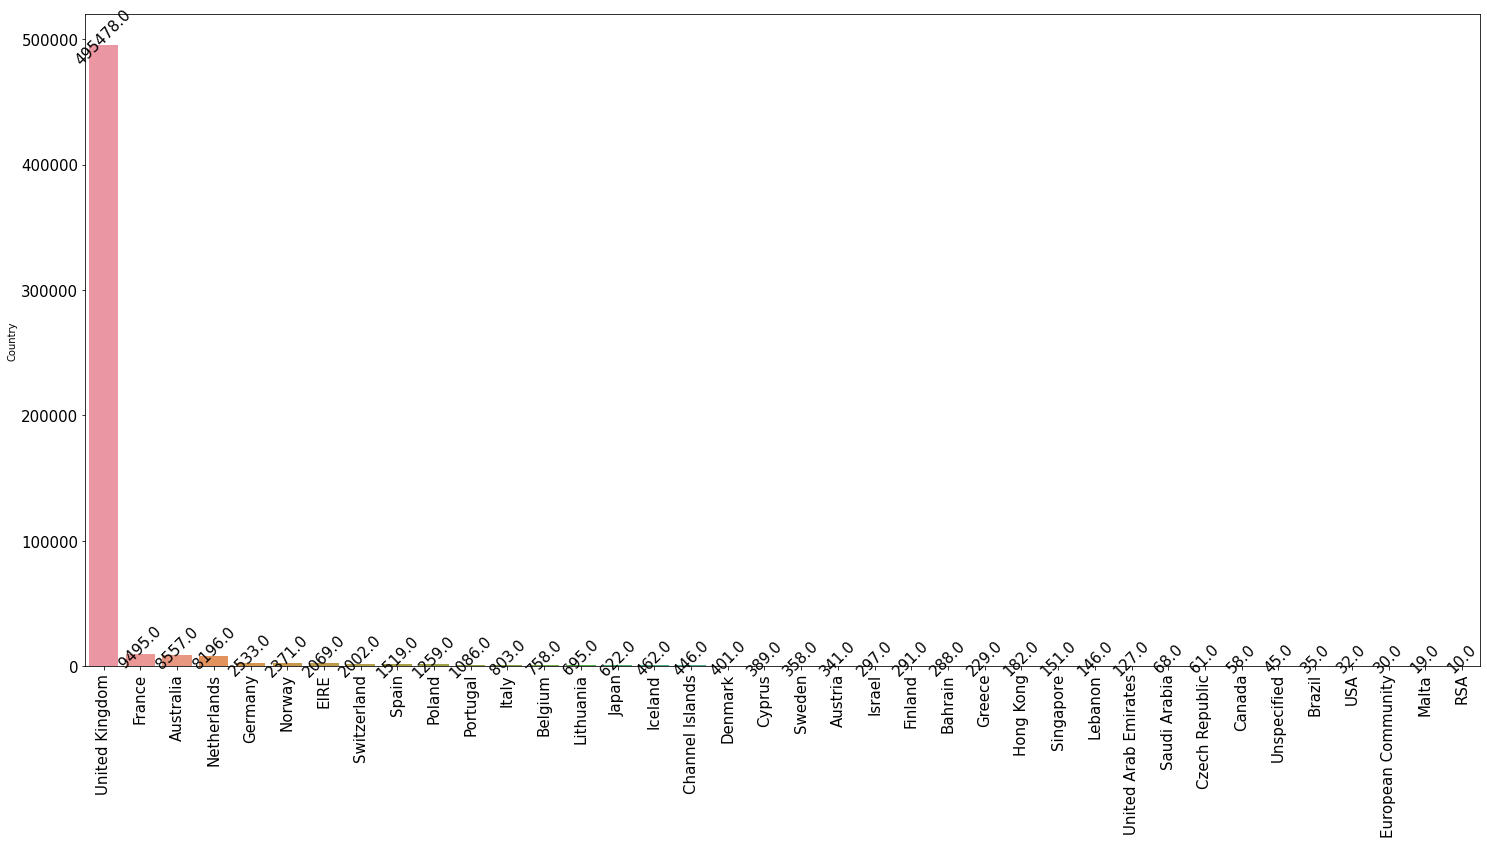

====================== Continent ======================


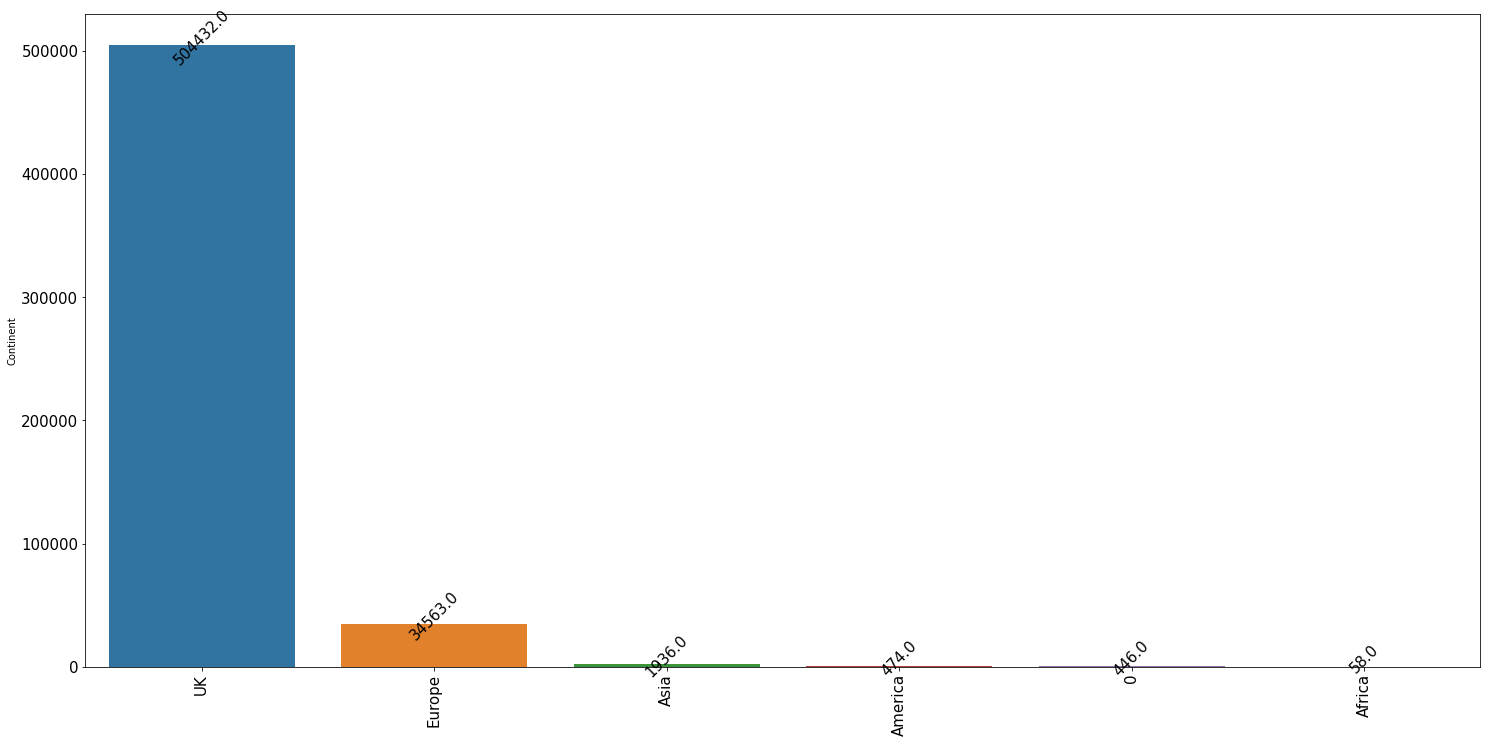

====================== Month ======================


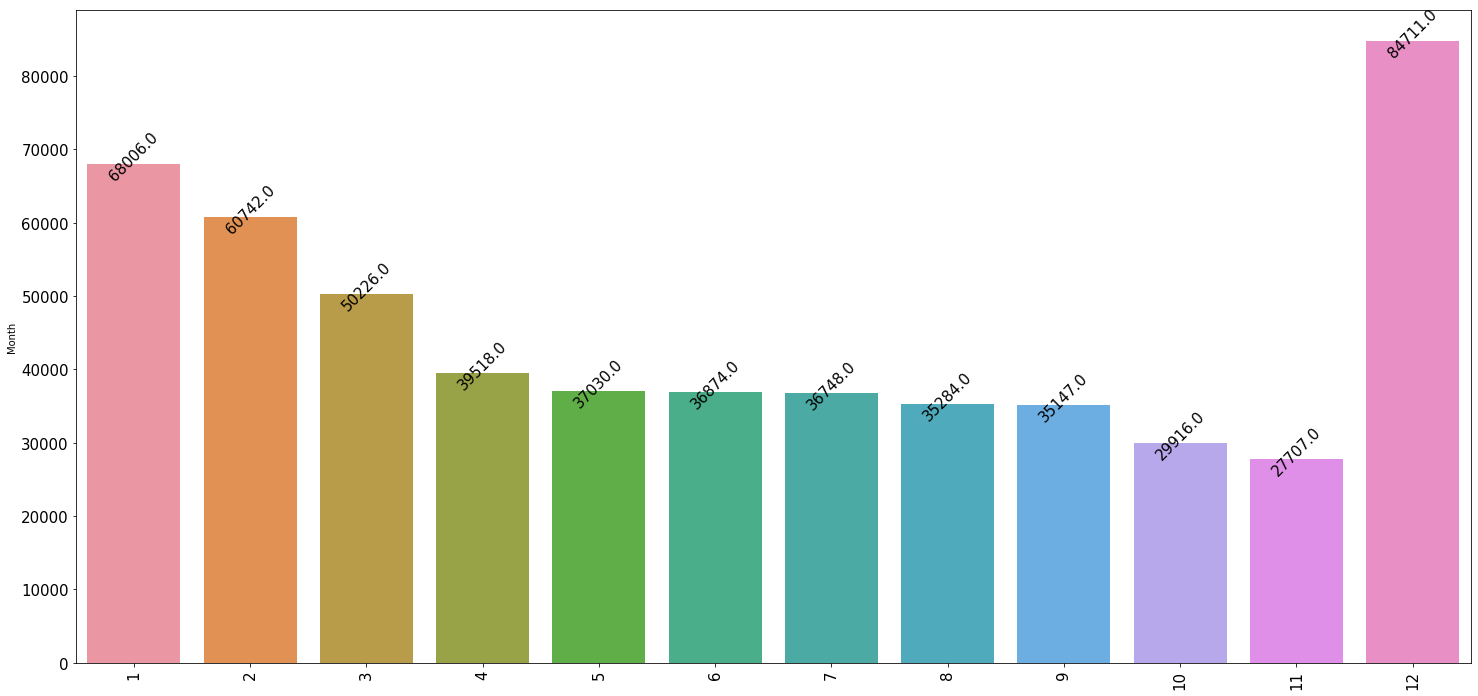

====================== Year ======================


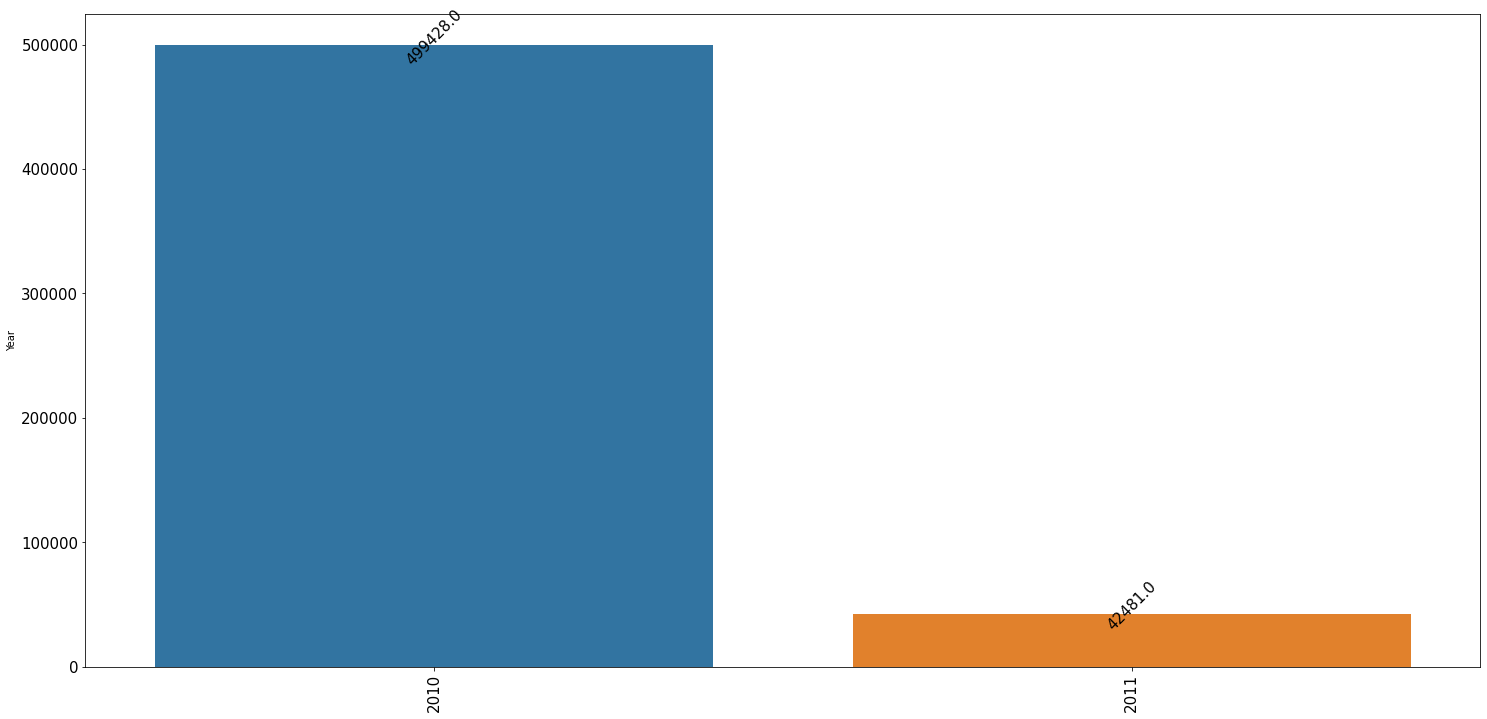

In [15]:
for obj in objs:
    print('======================', obj, '======================')
    single_categorical(obj)

- The most transaction recorded in United Kingdom with 500k record. I can say that the main market of the company is The UK area (Continent plot).
- Most of the transaction recorded in 2010, so there is a imbalance in the year data.

### 2.1.2 Numerical Analysis

In [16]:
#take all numerical feature, except object and datetime.
nums = ['Quantity', 'UnitPrice']
i = 1
for num in nums:
  print(i, '/', num, '\t', len(df[num].unique()), df[num].unique())
  i +=1

1 / Quantity 	 722 [     6      8      2     32      3      4     24     12     48     18
     20     36     80     64     10    120     96     23      5      1
     -1     50     40    100    192    432    144    288    -12    -24
     16      9    128     25     30     28      7     56     72    200
    600    480     -6     14     -2     11     33     13     -4     -5
     -7     -3     70    252     60    216    384    -10     27     15
     22     19     17     21     34     47    108     52  -9360    -38
     75    270     42    240     90    320   1824    204     69    -36
   -192   -144    160   2880   1400     39    -48    -50     26   1440
     31     82     78     97     98     35     57    -20    110    -22
    -30    -70   -130    -80   -120    -40    -25    -14    -15    -69
   -140   -320     -8    720    156    324     38     37     49     95
     -9    -11     29     41    -72    -35    -21    -43    -19    -18
    -44    402    378    150    300     54    104     67  

The value of the UnitPrice and Quantity are really high with some value. That is outliers so that it need to be deleted to fit the model.

In [17]:
#Continuous
def single_continuous(a):
    print(df[a].describe())
    print('Giá trị trung vị: ', df[a].median())
    print('Giá trị mode: ', df[a].mode())
    print('Measure of Dispersion: ',np.ptp(df[a]))
    print('==================================')
    Q1 = np.percentile(df[a], 25)
    Q3 = np.percentile(df[a], 75)
    print('Q1 = ', Q1,'\n','Q3 = ', Q3)
    print('==================================')
    print('Phương sai (Variance) = ', df[a].var())
    print('Độ lệch chuẩn (std) = ', df[a].std())
    print('==================================')
    print('Skew = ', df[a].skew())
    print('scipy Skew = ', scipy.stats.skew(df[a]))
    print('==================================')
    print('Kurtoisis = ',df[a].kurtosis())
    print('scipy kurtosis = ', scipy.stats.kurtosis(df[a]))
    print('==================================')
    plt.figure(figsize =(10,8))
    plt.subplot(1,2,1)
    sns.distplot(df[a])
    plt.subplot(1,2,2)
    plt.hist(df[a])
    plt.xticks(rotation = 30)
    plt.ticklabel_format(style='plain')
    plt.show()
    print('==================================')
    plt.figure(figsize = (4,8))
    plt.boxplot(df[a])
    plt.show()

===================== Quantity =====================
count    541909.000000
mean          9.552250
std         218.081158
min      -80995.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: Quantity, dtype: float64
Giá trị trung vị:  3.0
Giá trị mode:  0    1
dtype: int64
Measure of Dispersion:  161990
Q1 =  1.0 
 Q3 =  10.0
Phương sai (Variance) =  47559.3914092986
Độ lệch chuẩn (std) =  218.08115785023384
Skew =  -0.2640763070668848
scipy Skew =  -0.26407557610510857
Kurtoisis =  119769.16003068598
scipy kurtosis =  119768.05495538174


c:\program files\python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


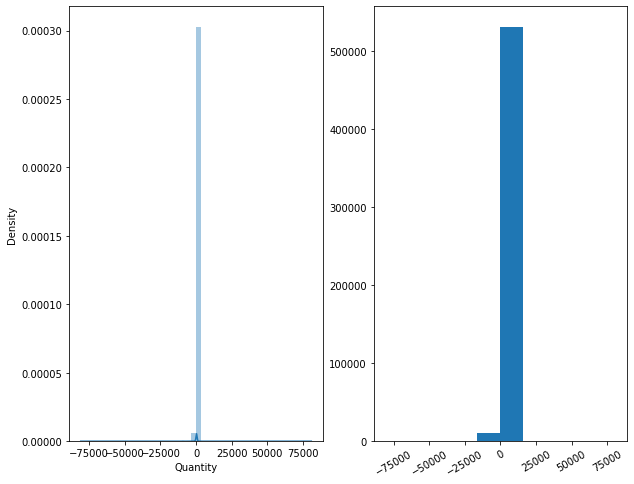

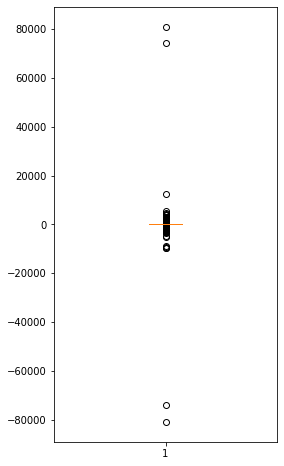

===================== UnitPrice =====================
count    541909.000000
mean          4.611114
std          96.759853
min      -11062.060000
25%           1.250000
50%           2.080000
75%           4.130000
max       38970.000000
Name: UnitPrice, dtype: float64
Giá trị trung vị:  2.08
Giá trị mode:  0    1.25
dtype: float64
Measure of Dispersion:  50032.06
Q1 =  1.25 
 Q3 =  4.13
Phương sai (Variance) =  9362.469164421025
Độ lệch chuẩn (std) =  96.75985306117938
Skew =  186.50697172054137
scipy Skew =  186.50645547026195
Kurtoisis =  59005.71909694814
scipy kurtosis =  59005.1746626736


c:\program files\python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


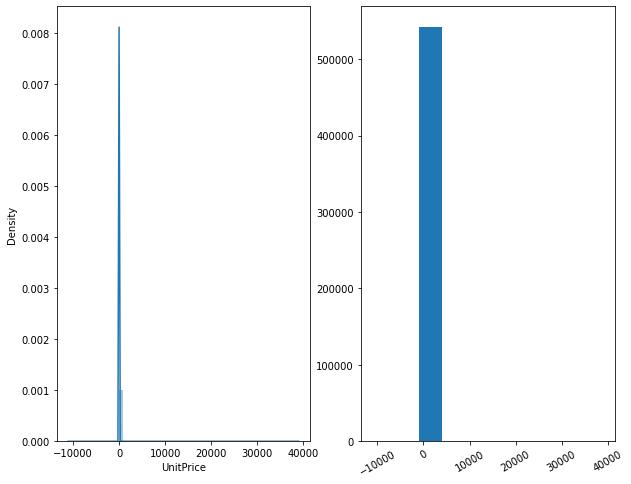

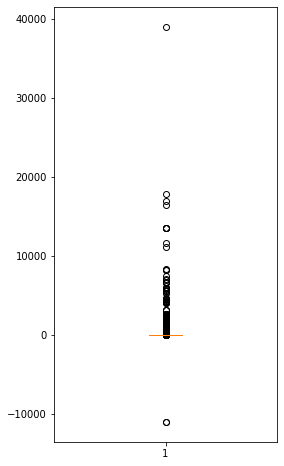

In [18]:
for num in nums:
  print('=====================',num,'=====================')
  single_continuous(num)

- The value of Quantity and UnitPrice are too big so it definetly have skew. UnitPrice have a strongly right skewwness.
- I will make a scale for the data.

## 2.2 Multivariable Analysis

### 2.2.1 Continuous & Continuous

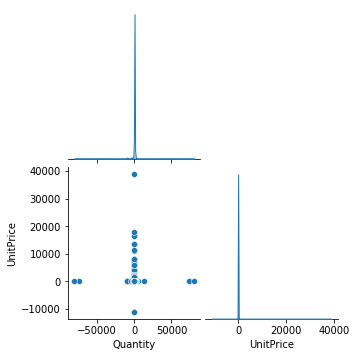

In [19]:
sns.pairplot(df[['Quantity', 'UnitPrice']].reset_index(drop = True),
             diag_kind = 'kde', palette = 'tab10', corner = True)

In [20]:
df.corr()

,Quantity,UnitPrice,CustomerID,Total_Sales,Month,Year
Quantity,1.000000,-0.001235,-0.003600,0.886681,-0.001116,0.002001
UnitPrice,-0.001235,1.000000,-0.004560,-0.162029,-0.000497,-0.004586
CustomerID,-0.003600,-0.004560,1.000000,-0.002274,0.030612,-0.035955
Total_Sales,0.886681,-0.162029,-0.002274,1.000000,0.000141,0.000275
Month,-0.001116,-0.000497,0.030612,0.000141,1.000000,-0.369595
Year,0.002001,-0.004586,-0.035955,0.000275,-0.369595,1.000000


### 2.2.2 Continuous & Category
- Continuous: 'Quantity', 'UnitPrice'
- Category: 'InvoiceNo', 'StockCode', 'CustomerID', 'Country'

In [21]:
def anova(f1, f2, f3, data):
    print('-'*20, 'Anova between {}, {} and {}'.format(f1,f2,f3), '-'*20)
    model = ols('{} ~ C({}) + C({}) + C({}):C({})'.format(f1,f2,f3,f2,f3), data = data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    return anova_table
def tukeyhsd(f1, f2, f3, data):
    print('-'*20, 'TukeyHSD test between {}, {} and {}'.format(f1,f2,f3), '-'*20)
    print('\n')
    for name, grouped_df in data.groupby(f2):
        print('{} {}'.format(f2, name), pairwise_tukeyhsd(grouped_df[f1],
                                                         grouped_df[f3], alpha = 0.05))

The continous and category will not be test due to my computer limitation and the category value is too big.

### 2.2.3 Category & Category

In [22]:
def two_categorical(table):
  stat, p, dof, expected = chi2_contingency(table)
  print('dof = %d' % dof)
  #print(expected)
  print('==============Interpret test-statistic===============')
  prob = 0.95
  critical = chi2.ppf(prob, dof)
  print('Probability = %.3f, Criticcal = %.3f, Stat = %.3f' %(prob, critical, stat))
  if abs(stat) >= critical:
    print('Dependent (Reject H0)')
  else:
    print('Independent (Fail to reject H0)')
  print('==============Interpret P-value===============')
  alpha = 1-prob
  print('Significance = %.3f, p = %.3f' %(alpha, p))
  if p<alpha:
    print('Dependent (Reject H0)')
  else:
    print('Independent (Fail to reject H0)')

In [23]:
table1 = pd.crosstab(df['StockCode'], df['Country'])
table2 = pd.crosstab(df['Country'], df['CustomerID'])
table3 = pd.crosstab(df['Country'], df['InvoiceNo'])
table4 = pd.crosstab(df['InvoiceNo'], df['StockCode'])
table5 = pd.crosstab(df['InvoiceNo'], df['CustomerID'])
table6 = pd.crosstab(df['StockCode'], df['CustomerID'])

In [24]:
table = [table1, table2, table3, table4, table5, table6]
for i in table:
    print()
    two_categorical(i)


dof = 150553
==============Interpret test-statistic===============
Probability = 0.950, Criticcal = 151456.718, Stat = 227193.728
Dependent (Reject H0)
==============Interpret P-value===============
Significance = 0.050, p = 0.000
Dependent (Reject H0)

dof = 157356
==============Interpret test-statistic===============
Probability = 0.950, Criticcal = 158279.885, Stat = 14538442.950
Dependent (Reject H0)
==============Interpret P-value===============
Significance = 0.050, p = 0.000
Dependent (Reject H0)

dof = 958263
==============Interpret test-statistic===============
Probability = 0.950, Criticcal = 960541.250, Stat = 20050633.000
Dependent (Reject H0)
==============Interpret P-value===============
Significance = 0.050, p = 0.000
Dependent (Reject H0)

dof = 105383031
==============Interpret test-statistic===============
Probability = 0.950, Criticcal = 105406911.767, Stat = 227007447.945
Dependent (Reject H0)
==============Interpret P-value===============
Significance = 0.050, p =

All categorical can successfully reject H0 so that there is a dependent relationship between them.

# 2.3 Data Visualization

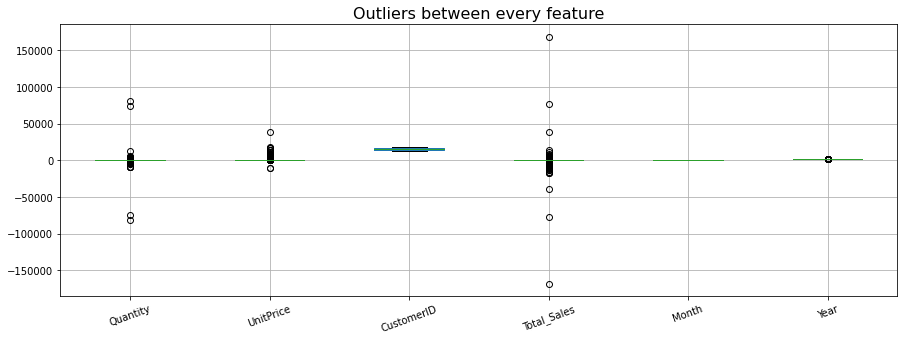

In [11]:
plt.figure(figsize = (15,5))
df.boxplot()
plt.xticks(rotation = 20)
plt.title('Outliers between every feature', size = 16)
plt.savefig("boxplot.png")
plt.show()

The outlier located both positive and negative value of Quantity, UnitPrice and Total Sales

In [12]:
quantity_country = df[['Country', 'Quantity']].groupby(['Country']).sum().sort_values(by = 'Quantity', ascending = False)

In [13]:
quantity_country[:10]

,Quantity
Country,
United Kingdom,4263829
Netherlands,200128
EIRE,142637
Germany,117448
France,110480
Australia,83653
Sweden,35637
Switzerland,30325
Spain,26824


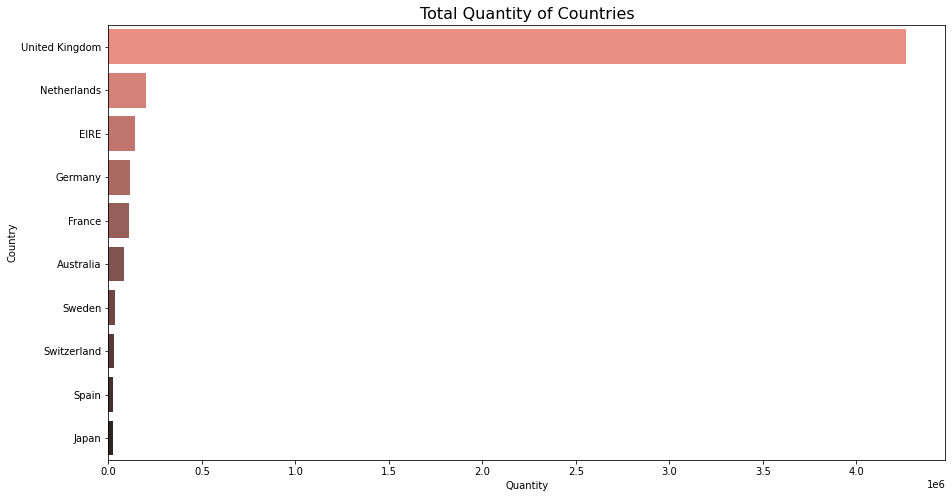

In [17]:
plt.figure(figsize = (15, 8))
sns.barplot(x="Quantity",  y= quantity_country[:10].index, 
            data=quantity_country[:10], ci = 0, palette = 'dark:salmon_r')
plt.title("Total Quantity of Countries", size = 16)
plt.savefig("total_quantity.png")

- This plot show the total Quantity of every country, because United Kingdom is the main market so it is the higest.
- The second main market is Europe area as you can see in the plot, except UK and Japan, all the rest country are Europe.

In [15]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Continent,Total_Sales,Month,Year
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,UK,15.30,12,2010
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,UK,20.34,12,2010
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,UK,22.00,12,2010
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,UK,20.34,12,2010
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,UK,20.34,12,2010


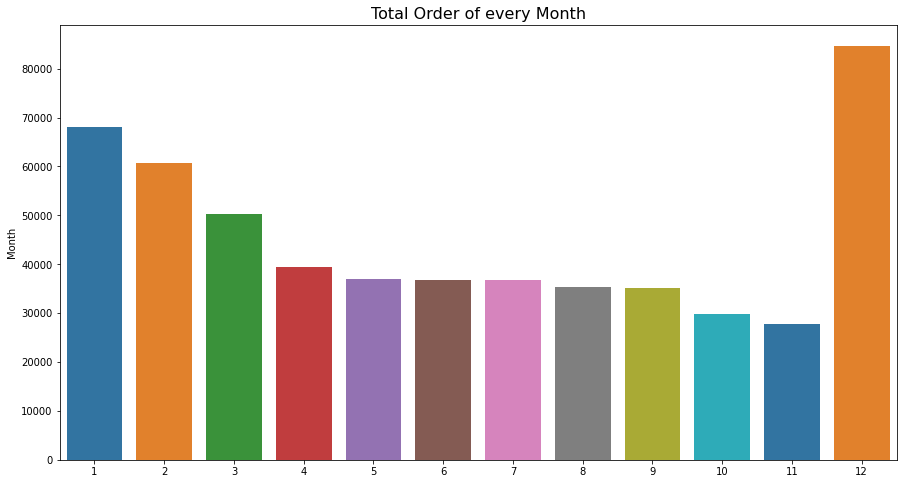

In [16]:
plt.figure(figsize = (15, 8))
sns.barplot(y= df['Month'].value_counts(),  x= df['Month'].unique(),
            data=df, ci = 0, palette = 'tab10')
plt.title("Total Order of every Month", size = 16)
plt.savefig("month_count.png")

The business Order record raised ai the beginning of Nov until Jan, then droped down slowly.

In [31]:
df['Continent'].unique()

array(['UK', 'Europe', 'Asia', 'America', '0', 'Africa'], dtype=object)

<AxesSubplot:ylabel='Continent'>

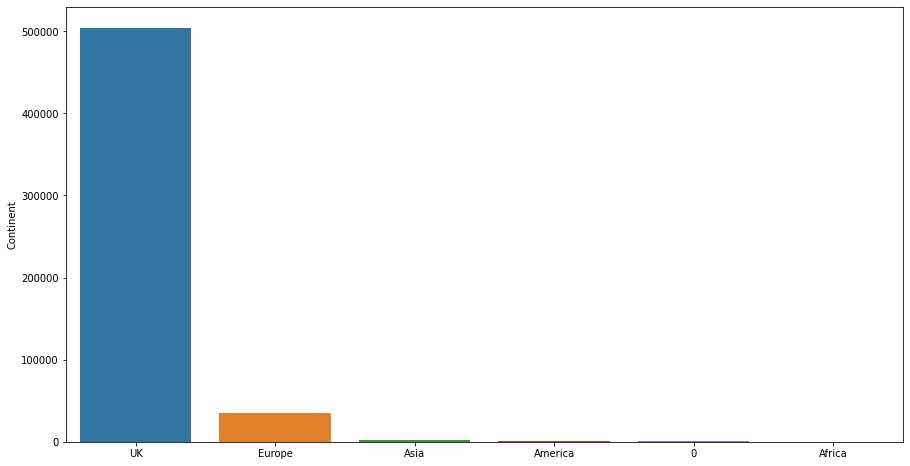

In [32]:
plt.figure(figsize = (15, 8))
sns.barplot(y= df['Continent'].value_counts(),  x= df['Continent'].unique(),
            data=df, ci = 0, palette = 'tab10')

# 3.Data Preparation

## 3.1 Data consolidation

## 3.2 Data cleaning

In [18]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
Continent           0
Total_Sales         0
Month               0
Year                0
dtype: int64

In [19]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
Continent           0
Total_Sales         0
Month               0
Year                0
dtype: int64

CustomerID have 135k value is null so I will filter the data does not have null value.

In [20]:
#function calculate amount of missing value
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    return mis_val_table_ren_columns

In [21]:
missing_values_table(df)

Your selected dataframe has 12 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
CustomerID,135080,24.9
Description,1454,0.3


CustomerID and Description both have missing values => Eliminate.

In [22]:
df = df[df['CustomerID'].isna() != True]

In [23]:
df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
Continent      0
Total_Sales    0
Month          0
Year           0
dtype: int64

There is no null value anymore.

- In this case, to make sure the StockCode and Description contain valid value so that I took a look at the data filter in Excel. This method suggested by AndrewNg called Eyeball data, the data checked by taking a look at very single value to make sure we do not skip the invalid value thet may harm the model.
- After use the Excel filter, I already aggregated invalid values into link_of_junk_StockCode and  link_of_junk_Description.

In [24]:
list_of_junk_StockCode = ['D', 'S', 'M', 'Post', 'DOT', 'BANK CHARGE', 'AMAZONFEE', 'CRUK']
for i in list_of_junk_StockCode:
    df = df[df['StockCode'] != i]

In [25]:
list_of_junk_description = ['20713', '?', '??', '???', '?display?', '?lost', '?sold as sets?', '?? missing', '???lost',
                            '????missing', '????damages????', '*Boombox Ipod Classic', '*USB Office Mirror Ball']
for i in list_of_junk_description:
    df = df[df['Description'] != i]

Delete some unvalid StockCode and Description value (I have take a look at the data in Excel before)

In [26]:
df[df['Description'] == '?']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Continent,Total_Sales,Month,Year


Check for random unvalid value, there is no unvalid anymore

In [27]:
#Take only the successfull Invoice where Quantity >0/
df = df[df['Quantity'] >0]

In [28]:
#Outlier detection function
def outliers_detect(df ,f):
    Q1 = np.percentile(df[f], 25)
    Q3 = np.percentile(df[f], 75)

    upper_outlier = df[df[f] > (Q3 + 1.5*(Q3 - Q1))].shape[0]
    lower_outlier = df[df[f] < (Q1 - 1.5*(Q3 - Q1))].shape[0]
    print('Percentage of outlier in dataset:', round(((upper_outlier+lower_outlier)/df.shape[0])*100,2),'%')
    print('Number of outliers in dataset:', upper_outlier + lower_outlier)

In [29]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'Continent', 'Total_Sales',
       'Month', 'Year'],
      dtype='object')

In [30]:
feature = ['Quantity', 'UnitPrice', 'Total_Sales']
for i in feature:
    print('====================',i, '====================')
    outliers_detect(df,i)
    print()

==================== Quantity ====================
Percentage of outlier in dataset: 6.45 %
Number of outliers in dataset: 25629

==================== UnitPrice ====================
Percentage of outlier in dataset: 8.61 %
Number of outliers in dataset: 34254

==================== Total_Sales ====================
Percentage of outlier in dataset: 7.84 %
Number of outliers in dataset: 31164



All three feature have outliers => delete outlier in the data

In [31]:
Q1 = np.percentile(df['Quantity'], 25)
Q3 = np.percentile(df['Quantity'], 75)

upper_outlier = df[df['Quantity'] > (Q3 + 1.5*(Q3 - Q1))].shape[0]
lower_outlier = df[df['Quantity'] < (Q1 - 1.5*(Q3 - Q1))].shape[0]

In [32]:
df = df[(df['Quantity'] < (Q3 + 1.5*(Q3 - Q1))) & (df['Quantity'] > (Q1 - 1.5*(Q3 - Q1)))]

In [33]:
Q1 = np.percentile(df['UnitPrice'], 25)
Q3 = np.percentile(df['UnitPrice'], 75)

upper_outlier = df[df['UnitPrice'] > (Q3 + 1.5*(Q3 - Q1))].shape[0]
lower_outlier = df[df['UnitPrice'] < (Q1 - 1.5*(Q3 - Q1))].shape[0]

In [34]:
df = df[(df['UnitPrice'] < (Q3 + 1.5*(Q3 - Q1))) & (df['UnitPrice'] > (Q1 - 1.5*(Q3 - Q1)))]

In [35]:
Q1 = np.percentile(df['Total_Sales'], 25)
Q3 = np.percentile(df['Total_Sales'], 75)

upper_outlier = df[df['Total_Sales'] > (Q3 + 1.5*(Q3 - Q1))].shape[0]
lower_outlier = df[df['Total_Sales'] < (Q1 - 1.5*(Q3 - Q1))].shape[0]

In [36]:
df = df[(df['Total_Sales'] < (Q3 + 1.5*(Q3 - Q1))) & (df['Total_Sales'] > (Q1 - 1.5*(Q3 - Q1)))]

In [37]:
df.shape

(324081, 12)

## 3.3 Data transformation

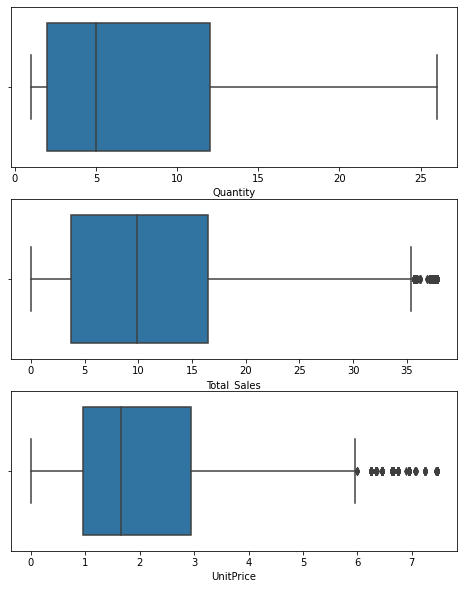

In [38]:
plt.figure(figsize = (8, 10))
plt.subplot(3,1,1)
sns.boxplot(data = df, x = 'Quantity')
plt.subplot(3,1,2)
sns.boxplot(data = df, x = 'Total_Sales')
plt.subplot(3,1,3)
sns.boxplot(data = df, x = 'UnitPrice')
plt.show()

The value of 3 variable after delete outliers have been resized, there is no more large value anymore.

In [39]:
label_encode = preprocessing.LabelEncoder()
df['StockCode'] = label_encode.fit_transform(df['StockCode'])
df['Description'] = label_encode.fit_transform(df['Description'])
df = df.reset_index(drop = True)

In [40]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Continent,Total_Sales,Month,Year
0,536365,2953,3326,6,2010-12-01,2.55,17850.0,United Kingdom,UK,15.30,12,2010
1,536365,2408,3334,6,2010-12-01,3.39,17850.0,United Kingdom,UK,20.34,12,2010
2,536365,2603,771,8,2010-12-01,2.75,17850.0,United Kingdom,UK,22.00,12,2010
3,536365,2555,1617,6,2010-12-01,3.39,17850.0,United Kingdom,UK,20.34,12,2010
4,536365,2554,2488,6,2010-12-01,3.39,17850.0,United Kingdom,UK,20.34,12,2010


In [41]:
df.to_csv("df_preprocess.csv")

# 4&5: Modeling and Evaluating

##### Create RFM dataframe by grouping CustomerID and make caculation for some new feature

In [42]:
max_date = df['InvoiceDate'].max().date()

Recency = lambda x: (max_date - x.max().date()).days
Frequency = lambda x: len(x.unique())
Monetary = lambda x: round(sum(x),2)

df_RFM = df.groupby('CustomerID').agg({'InvoiceDate':Recency,
                                       'InvoiceNo':Frequency,
                                       'Total_Sales':Monetary})

In [43]:
df_RFM.columns = ['Recency', 'Frequency', 'Monetary']
df_RFM = df_RFM.sort_values('Monetary', ascending = False)

In [44]:
df_RFM.head()

,Recency,Frequency,Monetary
CustomerID,,,
14911.0,1,188,70245.51
14096.0,4,17,31267.34
17841.0,1,123,30100.22
13089.0,4,76,23774.91
12748.0,0,193,19402.70


c:\program files\python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\program files\python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\program files\python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-

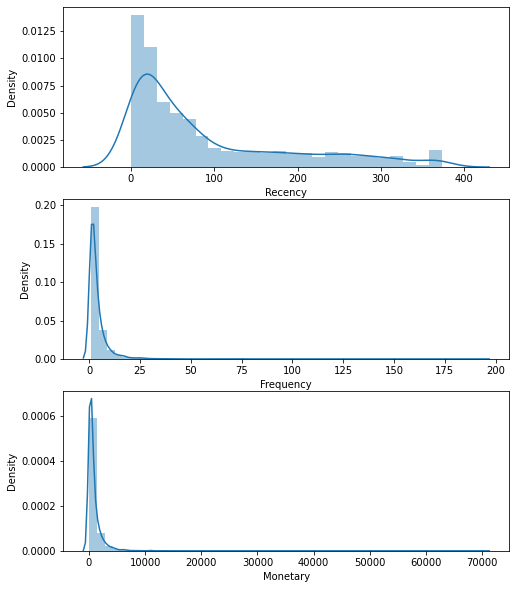

In [46]:
plt.figure(figsize = (8, 10))
plt.subplot(3,1,1)
sns.distplot(df_RFM['Recency'])

plt.subplot(3,1,2)
sns.distplot(df_RFM['Frequency'])

plt.subplot(3,1,3)
sns.distplot(df_RFM['Monetary'])
plt.savefig("rfm_distribution.png")
plt.show()

Most of the new feature have strong right skewness so make some scaling method will make the data fit with clustering model.

In [47]:
#create label
r_labels = range(4,0,-1)
f_labels = range(1,5)
m_labels = range(1,5)

In [48]:
[*r_labels]

[4, 3, 2, 1]

In [49]:
#assign these labels to 4 equal percentile gr
r_groups = pd.qcut(df_RFM['Recency'].rank(method = 'first'), q = 4, labels = r_labels)

f_groups = pd.qcut(df_RFM['Frequency'].rank(method = 'first'), q = 4, labels = f_labels)

m_groups = pd.qcut(df_RFM['Monetary'].rank(method = 'first'), q = 4, labels = m_labels)

In [50]:
#create new columns R, F, M
df_RFM  =df_RFM.assign(R = r_groups.values, F = f_groups.values, M = m_groups.values)

In [51]:
df_RFM.head()

,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
14911.0,1,188,70245.51,4,4,4
14096.0,4,17,31267.34,4,4,4
17841.0,1,123,30100.22,4,4,4
13089.0,4,76,23774.91,4,4,4
12748.0,0,193,19402.70,4,4,4


In [52]:
#concat rfm quartile
def join_rfm(x): return str(int(x['R'])) + str(int(x['F'])) + str(int(x['M']))
df_RFM['RFM_Segment'] = df_RFM.apply(join_rfm, axis = 1)

In [53]:
df_RFM.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment
CustomerID,,,,,,,
14911.0,1,188,70245.51,4,4,4,444
14096.0,4,17,31267.34,4,4,4,444
17841.0,1,123,30100.22,4,4,4,444
13089.0,4,76,23774.91,4,4,4,444
12748.0,0,193,19402.70,4,4,4,444


In [54]:
#calculate RFM score
df_RFM['RFM_Score'] = df_RFM[['R', 'F', 'M']].sum(axis = 1).astype('int')
df_RFM.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
14911.0,1,188,70245.51,4,4,4,444,12
14096.0,4,17,31267.34,4,4,4,444,12
17841.0,1,123,30100.22,4,4,4,444,12
13089.0,4,76,23774.91,4,4,4,444,12
12748.0,0,193,19402.70,4,4,4,444,12


In [55]:
df_RFM.groupby('RFM_Score').count()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment
RFM_Score,,,,,,,
3,159,159,159,159,159,159,159
4,589,589,589,589,589,589,589
5,528,528,528,528,528,528,528
6,473,473,473,473,473,473,473
7,411,411,411,411,411,411,411
8,402,402,402,402,402,402,402
9,411,411,411,411,411,411,411
10,370,370,370,370,370,370,370
11,341,341,341,341,341,341,341


In [56]:
def rfm_level(df):
    if (df['R'] == 4 and df['F'] ==4 and df['M'] == 4)  :
        return 'STARS'
    
    elif (df['R'] == 4 and df['F'] ==1 and df['M'] == 1):
        return 'NEW'
    
    else:     
        if df['M'] == 4:
            return 'BIG SPENDER'
        
        elif df['F'] == 4:
            return 'LOYAL'
        
        elif df['R'] == 4:
            return 'ACTIVE'
        
        elif df['R'] == 1:
            return 'LOST'
        
        elif df['M'] == 1:
            return 'LIGHT'
        
        return 'REGULARS'

In [57]:
df_RFM['RFM_Level'] = df_RFM.apply(rfm_level, axis = 1)

In [58]:
df_RFM.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level
CustomerID,,,,,,,,,
14911.0,1,188,70245.51,4,4,4,444,12,STARS
14096.0,4,17,31267.34,4,4,4,444,12,STARS
17841.0,1,123,30100.22,4,4,4,444,12,STARS
13089.0,4,76,23774.91,4,4,4,444,12,STARS
12748.0,0,193,19402.70,4,4,4,444,12,STARS


In [59]:
df_RFM['RFM_Level'].value_counts()

REGULARS       1008
LOST            977
BIG SPENDER     575
STARS           461
LIGHT           443
ACTIVE          371
LOYAL           287
NEW              23
Name: RFM_Level, dtype: int64

In [60]:
def RFM_Group(df):
    if df['RFM_Score'] < 5:
        return 'BOTTOM'
    elif (df['RFM_Score'] >=5 and df['RFM_Score'] < 9):
        return 'MIDDLE'
    else:
        return 'TOP'

- I will make a group based on the RFM_score feature.
    - The Top group: contain Customer have score from 9-12, the main profit of the company.
    - The middle group: contain Customer have score from 5-9, this group is a seasonal customer or we can say they are whosaler with quite small amount of Order and their profit does not big like the Top group. But they are still a good group to take care of.
    - The bottom group: is an individual customer, their amount of order is really small and they do not tend to buy often. So that we do not need to care about them because they does not the main profit source of the company, but we have to make sure that they still have good treatment when experiencing shopping at the counter.

In [61]:
df_RFM['RFM_Group'] = df_RFM.apply(RFM_Group, axis = 1)

In [62]:
df_RFM['RFM_Group'].value_counts()

MIDDLE    1814
TOP       1583
BOTTOM     748
Name: RFM_Group, dtype: int64

In [63]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_agg = df_RFM.groupby('RFM_Group').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']}).round(0)

rfm_agg.columns = rfm_agg.columns.droplevel()
rfm_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
rfm_agg['Percent'] = round((rfm_agg['Count']/rfm_agg.Count.sum())*100, 2)

# Reset the index
rfm_agg = rfm_agg.reset_index()


In [64]:
rfm_agg

,RFM_Group,RecencyMean,FrequencyMean,MonetaryMean,Count,Percent
0,BOTTOM,242.0,1.0,151.0,748,18.05
1,MIDDLE,90.0,2.0,350.0,1814,43.76
2,TOP,26.0,8.0,1749.0,1583,38.19


- The middle group accounted for 44% of the customer list, along with it is the Top group accounted for 38% of the data and the Monetary mean of Top group is 1700 which is the main profit of the company.
- The middle is the group have Frequency mean of 2.0, not much but it still be the side profit of the company, and their Recency mean showed that they have not return since 3 months ago, so that we must retarget them whenever the holiday will come up.

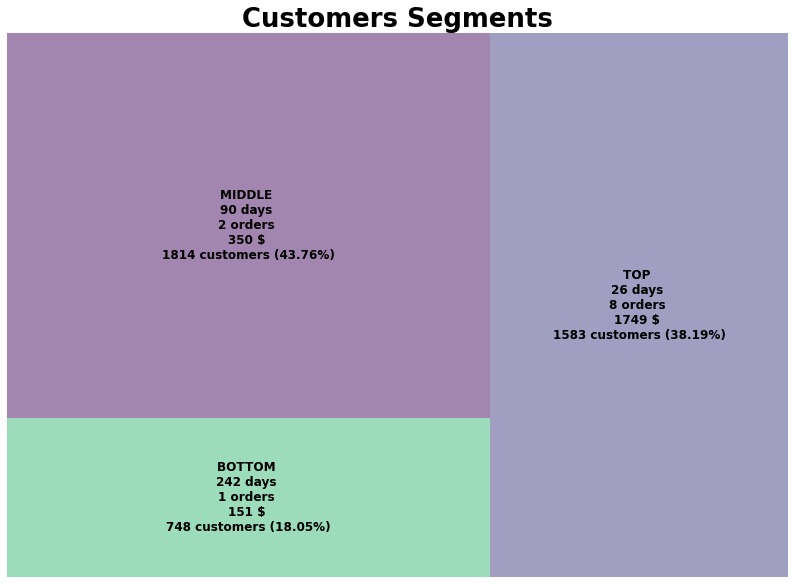

In [68]:
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)


squarify.plot(sizes=rfm_agg['Count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg.iloc[i])
                      for i in range(0, len(rfm_agg))], alpha=0.5,)


plt.title("Customers Segments",fontsize=26,fontweight="bold")
plt.axis('off')

plt.savefig('rfm_squarify.png')
plt.show()


In [76]:
import plotly.express as px

fig = px.scatter(rfm_agg, x="RecencyMean", y="MonetaryMean", size="FrequencyMean", color="RFM_Group",
           hover_name="RFM_Group", size_max=100, title = "The group Segmentation with Monetary and Recency")

#fig.write_image('rfm_group.png', engine='kaleido')
fig.show()

- As we see the Top group have the most Monetary Mean value which is the main profit.
- The bottom is the customer almost lost wherer the Recency mean is too high.

In [79]:
fig = px.scatter_3d(df_RFM, x='Recency', y='Frequency', z='Monetary',
                    color = 'RFM_Group', opacity=0.5, title = "RFM Group Segmentation")
fig.update_traces(marker=dict(size=5),
                  
                  selector=dict(mode='markers'))
fig.show()

- The group overlaping on each other, so the RFM is not good in this case, or the problem happended at the group rules.
##### I will take the RFM data (original and minmaxscale) for other model evaluating.

In [80]:
df_now = df_RFM[['Recency', 'Frequency', 'Monetary']]
df_now

,Recency,Frequency,Monetary
CustomerID,,,
14911.0,1,188,70245.51
14096.0,4,17,31267.34
17841.0,1,123,30100.22
13089.0,4,76,23774.91
12748.0,0,193,19402.70
...,...,...,...
16738.0,297,1,3.75
14101.0,294,1,2.95
16446.0,205,1,2.90


In [81]:
df_now.to_csv('rfs.csv')

In [82]:
minmax = MinMaxScaler()
X_minmax = minmax.fit_transform(df_now)
df_minmax = pd.DataFrame(X_minmax, columns = ['Recency', 'Frequency', 'Monetary'])

In [83]:
df_minmax

,Recency,Frequency,Monetary
0,0.002681,0.973958,1.000000
1,0.010724,0.083333,0.445102
2,0.002681,0.635417,0.428486
3,0.010724,0.390625,0.338439
4,0.000000,1.000000,0.276195
...,...,...,...
4140,0.796247,0.000000,0.000029
4141,0.788204,0.000000,0.000018
4142,0.549598,0.000000,0.000017
4143,0.018767,0.000000,0.000003


In [84]:
df_minmax.to_csv('rfm_minmax.csv')